# Object Detection w/ YOLOv2 (Darknet -> Caffe)
This tutorial demonstrates the steps required to prepare and deploy a trained Darknet model for FPGA acceleration  
We will prepare a trained YOLO v2 model, and then run a single detection.  

## Introduction
You only look once (YOLO) is a state-of-the-art, real-time object detection algorithm.  
The algorithm was published by Redmon et al. in 2016 via the following publications:
[YOLOv1](https://arxiv.org/abs/1506.02640),
[YOLOv2](https://arxiv.org/abs/1612.08242).  
The same author has already released YOLOv3, and some experimental tiny YOLO networks. We focus on YOLOv2.  
This application requires more than just simple classification. The task here is to detect the presence of objects, and localize them within a frame.  
Please refer to the papers for full algorithm details, and/or watch [this.](https://www.youtube.com/watch?v=9s_FpMpdYW8) 
In this tutorial, the network was trained on the 80 class [COCO dataset.](http://cocodataset.org/#home)

## Background
The authors of the YOLO papers used their own programming framework called "Darknet" for research, and development. 
The framework is written in C, and was [open sourced.](https://github.com/pjreddie/darknet)
Additionally, they host documentation, and pretrained weights [here.](https://pjreddie.com/darknet/yolov2/)
Currently, the Darknet framework is not supported by Xilinx's ML Suite.
Additionally, there are some aspects of the YOLOv2 network that are not supported by the Hardware Accelerator, such as the leaky ReLU activation function. For these reasons the network was modified, retrained, and converted to caffe. In this tutorial we will run the network accelerated on an FPGA using 16b quantized weights and a hardware kernel implementing a 56x32 systolic array with 5MB of image RAM. All convolutions/pools are accelerated on the FPGA fabric, while the final sigmoid, softmax, and non-max suppression functions are executed on the CPU.  

### Network Manual Modifications (Implemented directly in Darknet)
To accommodate FPGA acceleration, two modifications are required for the YOLOv2 network, and then retraining must occur: 
* Leaky ReLU replaced by ReLU (The FPGA HW does not support Leaky ReLU)
* "reorg" layer a.k.a. "space_to_depth" layer replaced by MAX POOL (W/H Dimensionality is maintained)
  * The reorg layer does not appreciably improve accuracy, and incurrs costly data movement penalties.
  * Converting to max pool preserves the dimensionality required for downstream layers.
  ``` 
  # Converting below layer to maxpool to preserve downstream HxW relationships
  # [reorg]
  # stride=2
  [maxpool]
  size=2
  stride=2
  ```

# Model Preparation (Offline Process, Performed Once):

## Phase 1: Convert to Caffe
Xilinx provides a darknet2caffe.py python script  
The script will take as arguments a darknet *.cfg file, and a darknet *.weights file, then generate a *.prototxt and a *.caffemodel.  
This is necessary for integration into the downstream components of ML-Suite.  
                                                                          

## Phase 2: Compile The Model  
    * A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
    * The network is optimized
    * FPGA Instructions are generated
      * These instructions are required to run the network in "one-shot", and minimize data movement

## Phase 3: Quantize The Model
    * The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT16 or INT8
    * This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve faster inference
      * While floating point precision is useful in the model training scenario
          It is not required for high speed, high accuracy inference
    
# Model Deployment (Online Process, Typically Performed Iteratively):  
    
## Phase 4: Deploy The Model
Once you have the outputs of the compiler and quantizer, you will use the xfDNN deployment APIs to:
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run the region layer on the CPU
7. Run non-max suppression on the CPU
8. Print the result (or send the result for further processing)
9. When you are done, close the handle to the FPGA
 

### Step 1. Import required packages, check environment.

In [1]:
import os,sys,cv2,timeit
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline


# Bring in Xilinx ML-Suite Compiler, Quantizer, PyXDNN
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from xfdnn.tools.quantize.quantize import CaffeFrontend as xfdnnQuantizer
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

# Bring in darknet2caffe functions
from darknet2caffe import *

# Bring in Non-Max Suppression 
import nms

# Bring in utility for drawing boxes
from yolo_utils import generate_colors, draw_boxes

# Ignore some warnings from the quantizer
import warnings
warnings.simplefilter("ignore", UserWarning)

print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])

!whoami # Must run as root if running on AWS EC2 F1, just check who you are below

# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables

Current working directory: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/notebooks
Running on host: xsjmanasab4-vcu1525
Running w/ LD_LIBRARY_PATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525/runtime/lib/x86_64/:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt/xdnn_cpp/build/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/ext/boost/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/notebooks
Running w/ XILINX_OPENCL: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525
Running w/ XCLBIN_PATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525
Running w/ PYTHONPATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/apps/yolo:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/apps/yolo/nms:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/emu:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/compile/network:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/

### Step 2. Use a config dictionary to pass parameters. Load and image from disk.

Here, we will setup and use a config dictionary to simplify handling of the arguments. For this example, we will attempt to classify a picture of a man standing on a horse. Image courtesy of openimages.


Runnning on VCU1525


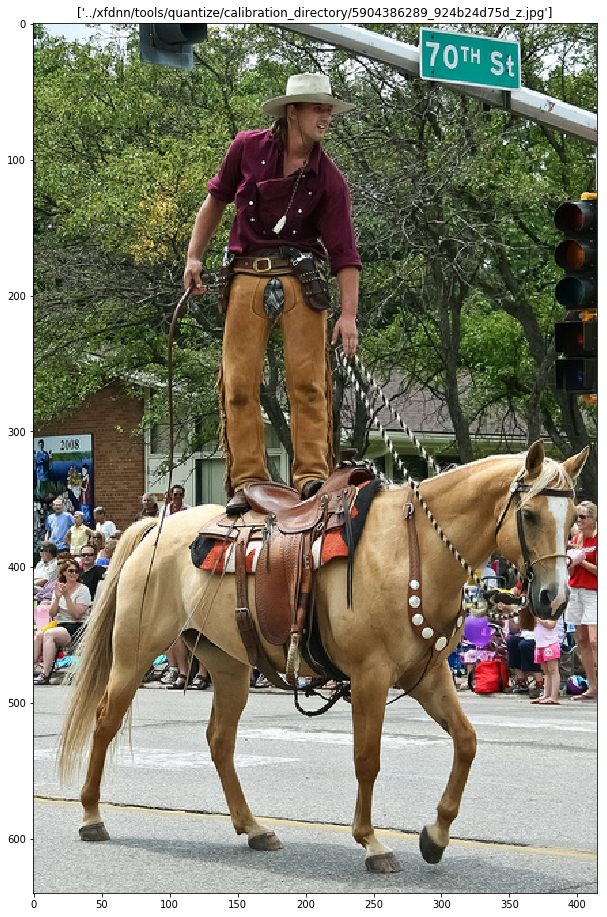

In [2]:
config = {}

# Quick check to see if we are running on AWS, if not assume 1525 or Nimbix box
if os.path.exists("/sys/hypervisor/uuid"):
    with open("/sys/hypervisor/uuid") as fp:
        contents = fp.read()
        if "ec2" in contents:
            print("Runnning on Amazon AWS EC2")
            config["device"] = "aws"
else:
    print("Runnning on VCU1525")
    config["device"] = "1525"

# Image of interest (Must provide as a list)
config["images"] = ["../xfdnn/tools/quantize/calibration_directory/5904386289_924b24d75d_z.jpg"]

img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title(config["images"])
plt.show()

### Step 3. Run darknet2caffe script.

Here, we need to convert the model from darknet to caffe. The below cell will create a prototxt, and a caffemodel in the ./work directory. Such a translation will be necessary for any model defined in darknet.

In [3]:
# Run the darknet2caffe python script which will convert a yolov2 darknet model to a caffe model
# This script additionally will remove batchnorm layers, by merging the parameters
# This step is intentionally performed upstream of the compiler due to Darknet's non-conforming implementation of 
#   batch normalization

config["prototxt"] = "./work/yolov2.prototxt" 
config["caffemodel"] = "./work/yolov2.caffemodel"

darknet2caffe("../models/yolov2/darknet/yolo.xdnn.nobn.cfg",
              "../models/yolov2/darknet/yolo.xdnn.nobn.weights",
              config["prototxt"],
              config["caffemodel"])

block:OrderedDict([('type', 'route'), ('layers', '-9')])
block:OrderedDict([('type', 'route'), ('layers', '-1,-4')])
from_layer: ['-1', '-4']
prev_layer_id1: 28
prev_layer_id2: 25
layer_id: 29
concat_layer: OrderedDict([('name', 'layer29-concat'), ('type', 'Concat'), ('bottom', ['layer28-maxpool', 'layer25-conv']), ('top', 'layer29-concat')])
net
convolutional
maxpool
convolutional
maxpool
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
convolutional
convolutional
convolutional
convolutional
route
convolutional
maxpool
route
convolutional
convolutional
region
============== unknow ==============
unknow layer type region 
save prototxt to ./work/yolov2.prototxt
save caffemodel to ./work/yolov2.caffemodel


### Step 4. Define an xfdnnCompiler instance and pass it arguments.  
To simplify handling of arguments, we continue to use a config dictionary. Take a look at the dictionary entries below. 

The arguments that need to be passed are: 
- `prototxt` - Caffe representation of the network
- `caffemodel` - Pre-trained Model for the network 
- `outmodel` - Filename for saving the prototxt and caffemodel of the optimized network
- `fpgacommands` - Filename to save micro-instruction produced by the compiler needed to deploy
- `memory` - Parameter to set the on-chip memory for the target xDNN overlay. This example will target an overlay with 5 MB of cache. 
- `dsp` - Parameter to set the size of the target xDNN overlay. This example uses an overlay of size 32x56 DSPs. 

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////  
Memory, and DSP are critical arguments that correspond to the hardware accelerator you plan to load onto the FPGA.  
The memory, and dsp parameters can be extracted from the name of the fpga programming file "xclbin".  
Don't worry about this detail for now. Just know that if you change the xclbin, you have to recheck these parameters.  
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////  

The xfDNN Compiler interfaces with Caffe to read a network graph, and generates a sequence of instructions for the xfDNN Deploy APIs to execute on the FPGA.  

During this process the xfDNN Compiler performs computational graph traversal, node merging and optimization, memory allocation and optimization and, finally, micro-instruction generation.
  

In [4]:
# Compiler Arguments
#config["prototxt"] = "./work/yolov2.prototxt" 
#config["caffemodel"] = "./work/yolov2.caffemodel"
config["outmodel"] = "work/optimized_model" # String for naming optimized prototxt, caffemodel
config["fpgacommands"] = "work/fpga.cmds" # Compiler will generate FPGA instructions
config["memory"] = 5 # Available on-chip SRAM
config["dsp"] = 56 # Width of Systolic Array

compiler = xfdnnCompiler(
    networkfile=config["prototxt"],       # Prototxt filename: input file
    weights=config["caffemodel"],         # Floating Point Weights: input file
    anew=config["outmodel"],              # String for intermediate prototxt/caffemodel
    generatefile=config["fpgacommands"],  # Script filename: output file
    memory=config["memory"],              # Available on chip SRAM within xclbin
    dsp=config["dsp"]                     # Rows in DSP systolic array within xclbin
)

# Invoke compiler
try:
    compiler.compile()

    # The compiler extracts the floating point weights from the .caffemodel. 
    # This weights dir will be stored in the work dir with the appendex '_data'. 
    # The compiler will name it after the caffemodel, and append _data
    config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data"
        
    if os.path.exists(config["datadir"]) and os.path.exists(config["fpgacommands"]+".json"):
        print("Compiler successfully generated JSON and the data directory: %s" % config["datadir"])
    else:
        print("Compiler failed to generate the JSON or data directory: %s" % config["datadir"])
        raise
        
    print("**********\nCompilation Successful!\n")
    
    import json
    data = json.loads(open(config["fpgacommands"]+".json").read())
    print("Network Operations Count: %d"%data['ops'])
    print("DDR Transfers (bytes): %d"%data['moveops']) 
    
except Exception as e:
    print("Failed to complete compilation:",e)


Network: ./work/yolov2.prototxt
GenerateCode: work/fpga.cmds
Weights: ./work/yolov2.caffemodel
PngFile: None
ConcatStrategy: None
Strategy: all
ScheduleFile: None
DSP: 56
Verbose: False
FromTF: False
Memory: 5
DDR: 256
Phase: TEST
RankDir: BT

**************************************************
* BUILDING DATA FLOW GRAPH
**************************************************

**************************************************
* BUILDING NETWORK SCHEDULE
**************************************************
Network Schedule ['data', 'layer1-conv', 'layer1-act', 'layer2-maxpool', 'layer3-conv', 'layer3-act', 'layer4-maxpool', 'layer5-conv', 'layer5-act', 'layer6-conv', 'layer6-act', 'layer7-conv', 'layer7-act', 'layer8-maxpool', 'layer9-conv', 'layer9-act', 'layer10-conv', 'layer10-act', 'layer11-conv', 'layer11-act', 'layer12-maxpool', 'layer13-conv', 'layer13-act', 'layer14-conv', 'layer14-act', 'layer15-conv', 'layer15-act', 'layer16-conv', 'layer16-act', 'layer17-conv', 'layer17-act', 'layer

### Step 5. Create Quantizer Instance and pass arguments.

To simplify handling of arguments, a config dictionary is used. Take a look at the dictionary below.

The arguments that need to be passed are:
- `deploy_model` - Filename generated by the compiler for the optimized prototxt and caffemodel.
- `quantizecfg` - Output JSON filename of quantization scaling parameters. 
- `bitwidths` - Desired precision from quantizer. This is to set the precision for [image data, weight bitwidth, conv output]. All three values need to be set to the same setting. The valid options are `16` for Int16 and `8` for Int8.  
- `in_shape` - Sets the desired input image size of the first layer. Images will be resized to these demensions and must match the network data/placeholder layer.
- `transpose` - Images start as H,W,C (H=0,W=1,C=2) transpose swaps to C,H,W (2,0,1) for typical networks.
- `channel_swap` - Depending on network training and image read, can swap from RGB (R=0,G=1,B=2) to BGR (2,1,0).
- `raw_scale` - Depending on network training, scale pixel values before mean subtraction.
- `img_mean` - Depending on network training, subtract image mean if available.
- `input_scale` - Depending on network training, scale after subtracting mean.
- `calibration_size` - Number of images the quantizer will use to calculate the dynamic range. 
- `calibration_directory` - Location of dir of images used for the calibration process. 

Below is an example with all the parameters filled in. `channel_swap` `raw_scale` `img_mean` `input_scale` are image preprocessing arguments specific to a given model.

In [5]:
# Use a config dictionary to pass parameters to the compiler
# Quantizer Arguments
#config["outmodel"] = Defined in Step 4 # String for naming intermediate prototxt, caffemodel
config["quantizecfg"] = "work/quantization_params.json" # Quantizer will generate quantization params
config["bitwidths"] = [16,16,16] # Supported quantization precision
config["in_shape"] = [3,608,608] # Images will be resized to this shape -> Needs to match prototxt
config["transpose"] = [2,0,1] # (H,W,C)->(C,H,W) transpose argument to quantizer
config["channel_swap"] = [2,1,0] # (R,G,B)->(B,G,R) Channel Swap argument to quantizer
config["raw_scale"] = 1.0 # Yolo effectively divides by 255 (Quantizer will represent image as 0 <-> 1 which is equiv)
config["img_mean"] = [0.0, 0.0, 0.0] # Mean of the training set used for mean subtraction (Not performed for yolo)
config["input_scale"] = 1.0 # Input multiplier, Images are scaled by this factor after mean subtraction
config["calibration_size"] = 15 # Number of calibration images quantizer will use
config["calibration_directory"] = "../xfdnn/tools/quantize/calibration_directory" # Directory of images

quantizer = xfdnnQuantizer(
    deploy_model=config["outmodel"]+".prototxt",        # Model filename: input file
    weights=config["outmodel"]+".caffemodel",           # Floating Point weights
    output_json=config["quantizecfg"],                    # Quantization JSON output filename
    bitwidths=config["bitwidths"],                        # Fixed Point precision: 8,8,8 or 16,16,16
    dims=config["in_shape"],                              # Image dimensions [C,H,W]
    transpose=config["transpose"],                        # Transpose argument to caffe transformer
    channel_swap=config["channel_swap"],                  # Channel swap argument to caffe transfomer
    raw_scale=config["raw_scale"],                        # Raw scale argument to caffe transformer
    mean_value=config["img_mean"],                        # Image mean per channel to caffe transformer
    input_scale=config["input_scale"],                    # Input scale argument to caffe transformer
    calibration_size=config["calibration_size"],          # Number of calibration images to use
    calibration_directory=config["calibration_directory"] # Directory containing calbration images
)

# Invoke quantizer
try:
    quantizer.quantize()

    import json
    data = json.loads(open(config["quantizecfg"]).read())
    print("**********\nSuccessfully produced quantization JSON file for %d layers.\n"%len(data['network']))
except Exception as e:
    print("Failed to quantize:",e)

Mean : [0. 0. 0.]
Adding ../xfdnn/tools/quantize/calibration_directory/13923040300_b4c8521b4d_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/14931486720_37bd588ce9_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/15439525724_97d7cc2c81_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/16247716843_b419e8b111_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3272651417_27976a64b3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3591612840_33710806df_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/36085792773_b9a3d115a3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4788821373_441cd29c9f_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4814953542_de4b973dc2_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directo

bw_layer_in:  16
th_layer_in:  25.913026809692383
bw_layer_out:  16
th_layer_out:  25.913026809692383
--------------------------------------------------------------------------------
Processing layer 14 of 54
Layer Name:layer9-conv Type:Convolution
Inputs: ['layer8-maxpool'], Outputs: ['layer9-conv']
Quantizing conv input layer ... layer9-conv
Threshold in shape= ()
Quantizing conv weights for layer layer9-conv...
Threshold params shape= (256,)
Min:  0 , Max:  15.807889
n:  32768 , len(bin_edges):  4711
Mean : th_layer_out:  15.807888984680176 , sf_layer_out:  0.00048243320977447356
Threshold out shape= ()
Min:  0 , Max:  15.807889
n:  32768 , len(bin_edges):  4711
Mean : th_layer_out:  15.807888984680176 , sf_layer_out:  0.00048243320977447356
bw_layer_in:  16
th_layer_in:  25.913026809692383
bw_layer_out:  16
th_layer_out:  15.807888984680176
--------------------------------------------------------------------------------
Processing layer 15 of 54
Layer Name:layer9-conv_relu Type:ReL

n:  32768 , len(bin_edges):  2356
Mean : th_layer_out:  18.412010192871094 , sf_layer_out:  0.0005619071075432933
bw_layer_out:  16
th_layer_out:  18.412010192871094
--------------------------------------------------------------------------------
Processing layer 29 of 54
Layer Name:layer17-conv Type:Convolution
Inputs: ['layer16-conv'], Outputs: ['layer17-conv']
Quantizing conv input layer ... layer17-conv
Threshold in shape= ()
Quantizing conv weights for layer layer17-conv...
Threshold params shape= (512,)
Min:  0 , Max:  15.443299
n:  32768 , len(bin_edges):  3332
Mean : th_layer_out:  15.443299293518066 , sf_layer_out:  0.0004713064758298919
Threshold out shape= ()
Min:  0 , Max:  15.443299
n:  32768 , len(bin_edges):  3332
Mean : th_layer_out:  15.443299293518066 , sf_layer_out:  0.0004713064758298919
bw_layer_in:  16
th_layer_in:  18.412010192871094
bw_layer_out:  16
th_layer_out:  15.443299293518066
-------------------------------------------------------------------------------

n:  32768 , len(bin_edges):  2356
Mean : th_layer_out:  15.215667724609375 , sf_layer_out:  0.0004643594996371158
bw_layer_in:  16
th_layer_in:  69.98736572265625
bw_layer_out:  16
th_layer_out:  15.215667724609375
--------------------------------------------------------------------------------
Processing layer 44 of 54
Layer Name:layer24-conv_relu Type:ReLU
Inputs: ['layer24-conv'], Outputs: ['layer24-conv']
Min:  0 , Max:  15.215668
n:  32768 , len(bin_edges):  2356
Mean : th_layer_out:  15.215667724609375 , sf_layer_out:  0.0004643594996371158
bw_layer_out:  16
th_layer_out:  15.215667724609375
--------------------------------------------------------------------------------
Processing layer 45 of 54
Layer Name:layer25-conv Type:Convolution
Inputs: ['layer24-conv'], Outputs: ['layer25-conv']
Quantizing conv input layer ... layer25-conv
Threshold in shape= ()
Quantizing conv weights for layer layer25-conv...
Threshold params shape= (1024,)
Min:  0 , Max:  13.806248
n:  32768 , len(bin

## Phase 4. Deploy The Model.
Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run region layer on the CPU
7. Run non-max suppression on the CPU
8. Print the result 
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use the `xdnn_v2_32x56_2pe_16b_6mb_bank21` overlay. You can learn about other overlay options in the ML Suite Tutorials [here][].  

[here]: https://github.com/Xilinx/ml-suite
        
### Step 6. Open a handle for FPGA communication.

In [6]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by pyxfdnn

# Chosen Hardware Overlay
#config["xclbin"] = "../overlaybins/" + config["device"] + "/xdnn_v2_32x56_2pe_16b_6mb_bank21.xclbin" 
config["xclbin"] = "../overlaybins/" + config["device"] + "/overlay_3.xclbin"
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

config["xfdnn_library"] = "../xfdnn/rt/xdnn_cpp/lib/libxfdnn.so" # Library functions called by pyXFDNN

ret = pyxfdnn.createHandle(config['xclbin'], "kernelSxdnn_0", config['xfdnn_library'])
if ret:                                                             
    print("ERROR: Unable to create handle to FPGA")
else:
    print("INFO: Successfully created handle to FPGA")
    
# If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware
# For instance the xclbin could have been built for the wrong DSA/shell

INFO: Successfully created handle to FPGA


### Step 7. Apply quantization scaling and transfer model weights to the FPGA. 

In [ ]:
# Quantize, and transfer the weights to FPGA DDR

# config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
config["scaleA"] = 10000 # Global scaler for weights (Must be defined, although not used)
config["scaleB"] = 30 # Global scaler for bias (Must be defined, although not used)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements

(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)

# Note that this function returns pointers to weights corresponding to the layers that will be implemented in the CPU

Loading weights/bias/quant_params to FPGA...


### Step 8. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [ ]:
# Allocate space in host memory for inputs, Load images from disk

config["transform"] = "yolo" # Letter-Boxing
config["firstfpgalayer"] = "layer1-conv" # Name of first layer to be ran on the FPGA -> Needs to match prototxt

(fpgaInputs, shapes, batch_sz) = pyxfdnn_io.prepareInput(config)

### Step 9. Allocate space in host memory for outputs.

In [ ]:
# Allocate space in host memory for outputs

# The output of a yolo network is more complex than most networks.

# In YOLOv2 the input image is square, and it is divided into grid cells of 32 pixels each.
# For example, a 608x608 image would yield a volume with HxW = 19x19. Where 19 = 608/32
#              a 224x224 image would yield a volume with HxW = 7x7
out_h = out_w = config["in_shape"][1] / 32

# For each grid cell in the input image, YOLOv2 considers the possibility of 5 objects being present (Anchor Boxes)
#   For each anchor box, YOLOv2 computes
#   - The probability that there is an object in the anchor box - 1 element
#   - The x,y,w,h coordinates of a bounding box (centroid and width height of box) - 4 elements
#   - The class probabilities (Number of classes depends on dataset) We use MS COCO which has 80 classes - 80 elements
anchor_boxes = 5
objectness = 1
coordinates = 4
classes = 80
out_c = objectness+coordinates+classes

# Number of elements in the activation of the last layer ran on the FPGA
config["fpgaoutsz"] = anchor_boxes*out_c*out_h*out_w 

fpgaOutputs = pyxfdnn_io.prepareOutput(config['fpgaoutsz'], batch_sz)

print ("YOLOv2 will produce an output volume of shape (%dx%dx%dx%d) consisting of %d elements" \
           %(anchor_boxes,out_c,out_h,out_w,config["fpgaoutsz"]))


### Step 10. Write optimized micro-code to the xDNN Processing Engine on the FPGA. Execute the network.

In [ ]:
# Write FPGA Instructions to FPGA and Execute the network!
if len(pyxfdnn._xdnnManager._handles) > 0: # Just make sure FPGA still available
    startTime = timeit.default_timer()
    pyxfdnn.execute(
        config["fpgacommands"],
        weightsBlob,
        fpgaInputs,
        fpgaOutputs,
        batch_sz, # Number of images we are processing
        config['quantizecfg'], 
        config['scaleB'], 
        config['PE']
    )
    elapsedTime = timeit.default_timer() - startTime
    print(elapsedTime*1000, "ms")
    
# Note that the time printed here is the time to transfer microcode to the FPGA + the time to execute
# Iterative calls to this cell will produce the real latency number

### Step 11. Execute the YOLOv2 region layer on the CPU.
The region layer requires the sigmoid function to be applied to the X/Y coordinates of each prediction, and the box confidence. It also requires the softmax to be computed across all class scores in each anchor box. Here we use numpy to acheive this.

In [ ]:
# Functions Required for implementing YOLOv2 region layer
# Implemented using numpy in a numerically stable manner
def sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return (e_x)/(e_x.sum(axis=0,keepdims=True))

startTime = timeit.default_timer()
# Reshape the fpgaOutputs into a 4D volume
fpgaOutputs = fpgaOutputs.reshape(anchor_boxes,out_c,out_h,out_w)

# Apply sigmoid to 1st, 2nd, 4th channel for all anchor boxes
fpgaOutputs[:,0:2,:,:] = sigmoid(fpgaOutputs[:,0:2,:,:]) # (X,Y) Predictions
fpgaOutputs[:,4,:,:]   = sigmoid(fpgaOutputs[:,4,:,:])   # Objectness / Box Confidence

# Apply softmax on the class scores foreach anchor box
for box in range(anchor_boxes):
    fpgaOutputs[box,5:,:,:]  = softmax(fpgaOutputs[box,5:,:,:])
    
elapsedTime = timeit.default_timer() - startTime
print(elapsedTime*1000, "ms")

### Step 12. Execute NMS on the CPU.
Non-Max Suppression is the algorithim used to filter out redundant predictions. For instance, yolo could have produced multiple bounding boxes for the same object. Additionally, predictions made with low confidence are thrown out.
We have encapsulated some C code for implementing NMS in a python wrapper.

In [ ]:
# Perform Non-Max Suppression
# Non-Max Suppression filters out detections with a score lesser than 0.24
# Additionally if there are two predections with an overlap > 30%, the prediction with the lower score will be filtered
scorethresh = 0.24
iouthresh = 0.3
bboxes = nms.do_baseline_nms(fpgaOutputs.flat,
                             shapes[0][1],
                             shapes[0][0],
                             config['in_shape'][2],
                             config['in_shape'][1],
                             out_w,
                             out_h,
                             anchor_boxes,
                             classes,
                             scorethresh,
                             iouthresh)

### Step 13. Print out results.
After NMS all operations are complete. Now we must print the results, and we can draw the detections on the original image for reference.

In [ ]:
# Create a list of class labels given a file containing the coco dataset classes
with open("../apps/yolo/coco.names") as f:      
    namez = f.readlines()      
    names = [x.strip() for x in namez]
    
# Lets print the detections our model made
for j in range(len(bboxes)):
    print("Obj %d: %s" % (j, names[bboxes[j]['classid']]))
    print("\t score = %f" % (bboxes[j]['prob']))
    print("\t (xlo,ylo) = (%d,%d)" % (bboxes[j]['ll']['x'], bboxes[j]['ll']['y']))
    print("\t (xhi,yhi) = (%d,%d)" % (bboxes[j]['ur']['x'], bboxes[j]['ur']['y']))
    
# Given the detection results above, lets draw our findings on the original image, and display it
colors = generate_colors(classes)
draw_boxes(config["images"][0],bboxes,names,colors,"./work","../apps/yolo/font",False)
outimage = "./work/5904386289_924b24d75d_z.jpg"
img = cv2.imread(outimage)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title("Output Image w/ Bounding Boxes Drawn")
plt.show()

### Step 14. Close the handle.

In [ ]:
pyxfdnn.closeHandle()

# C'est fini!